# Práctica: Predicción de Diabetes con ML (Pima Indians)
**Asignatura:** Sistemas Inteligentes  
**Objetivo:** construir un pipeline de Machine Learning con preprocesamiento, visualización, k-fold CV y ajuste automático de hiperparámetros para comparar modelos básicos.

Dataset recomendado: Kaggle *Pima Indians Diabetes Database* (`diabetes.csv`).  
- Kaggle: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database  
- Alternativa: UCI Machine Learning Repository.  

**Instrucciones previas:**
1. Descarga `diabetes.csv` y colócalo junto a este notebook (o ajusta la ruta en la celda de carga).
2. Requisitos: `scikit-learn`, `pandas`, `numpy`, `matplotlib`.

**Tareas a realizar**

1. Carga y Exploración del Dataset

- Cargar los datos en Python (pandas, scikit-learn, matplotlib, seaborn).
- Explorar el dataset: valores nulos, estadísticas descriptivas y correlaciones.
- Visualizar distribuciones y relaciones entre variables (ej. histogramas, boxplots, pairplots).
- Descripción del dataset:

| Columna                  | Descripción                                                             |
| ------------------------ | ----------------------------------------------------------------------- |
| Pregnancies              | Número de embarazos                                                     |
| Glucose                  | Concentración de glucosa en plasma a las 2h en una prueba de tolerancia |
| BloodPressure            | Presión arterial diastólica (mm Hg)                                     |
| SkinThickness            | Grosor del pliegue cutáneo del tríceps (mm)                             |
| Insulin                  | Insulina sérica en 2h (mu U/ml)                                         |
| BMI                      | Índice de masa corporal (peso/altura²)                                  |
| DiabetesPedigreeFunction | Función de pedigrí de diabetes (herencia genética)                      |
| Age                      | Edad del paciente                                                       |
| Outcome                  | Variable objetivo: 1 = diabético, 0 = no diabético                      |

2. Transformación y Preprocesamiento de Datos

- Normalización o estandarización de variables numéricas.
- Tratamiento de valores cero en atributos clínicos que no deberían ser cero (ej. Glucose, BloodPressure, BMI).
- Creación de conjuntos de entrenamiento y prueba (ej. 80%-20%).

3. Selección de Algoritmos

- Los alumnos deberán probar al menos tres algoritmos de machine learning clásicos:
- Regresión logística
- K-Nearest Neighbors (KNN)
- Árboles de decisión

4. Ajuste Automático de Hiperparámetros

- Usar GridSearchCV o RandomizedSearchCV de scikit-learn para optimizar hiperparámetros.
- Ejemplos de hiperparámetros a optimizar:
- KNN: número de vecinos, métrica de distancia.
- Árboles: profundidad máxima, criterio de división.
- Regresión logística: tipo de regularización, parámetro C.

5. Validación Cruzada (k-fold)

- Usar k-fold cross-validation (k=5 o k=10) para evaluar los modelos.
- Comparar los resultados promedio de accuracy, precision, recall y F1-score.

6. Visualización de Resultados

- Graficar curvas de precisión/recall o matriz de confusión.
- Mostrar la evolución del rendimiento según los hiperparámetros probados.
- Comparar en una tabla final el rendimiento de los tres algoritmos.

**Entregables:**
- Notebook ejecutado y comentado.
- Informe breve con tablas, gráficos y conclusiones sobre el mejor modelo.

Lo primero que hacemos es importar el dataset para analizar los datos que obtenemos. Tal y como podemos observar tenemos 9 columnas y 768 filas de datos. Entre esos datos tendremos valores nulos y outliers. Antes de proceder a tratar los datos procedo a simplemente quitar los valores nulos y probar los modelos de clasificacion para ver que tal funcionan de partida.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Mostramos los 10 primeros valores para ver que datos posee el dataset

In [2]:
df.head(n=10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [3]:
# Diccionarios para almacenar los nombres de las columnas
cols_numericas = []
cols_categoricas = []

# Obtener la serie de tipos de datos de las columnas
data_types = df.dtypes

# Iterar sobre las columnas y clasificar
for column, dtype in data_types.items():
    if pd.api.types.is_numeric_dtype(dtype):
        # Es numérico (int, float)
        cols_numericas.append(column)
    elif pd.api.types.is_object_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype):
        # Es categórico (string/object o tipo category explícito)
        cols_categoricas.append(column)
    else:
        # Otros tipos (como datetime, boolean, etc.)
        pass # Por simplicidad, nos centramos en los dos principales

print(f"\n Variables Numéricas ({len(cols_numericas)}):")
print(cols_numericas)

print(f"\n Variables Categóricas ({len(cols_categoricas)}):")
print(cols_categoricas)

# Puedes añadir una verificación extra para variables categóricas con pocos valores únicos
print("\n--- Verificación de Variables con Pocos Valores Únicos (Potencialmente Categóricas/Binarias) ---")


 Variables Numéricas (9):
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

 Variables Categóricas (0):
[]

--- Verificación de Variables con Pocos Valores Únicos (Potencialmente Categóricas/Binarias) ---


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

A continuación comprobamos que el dataset no posee valores null.

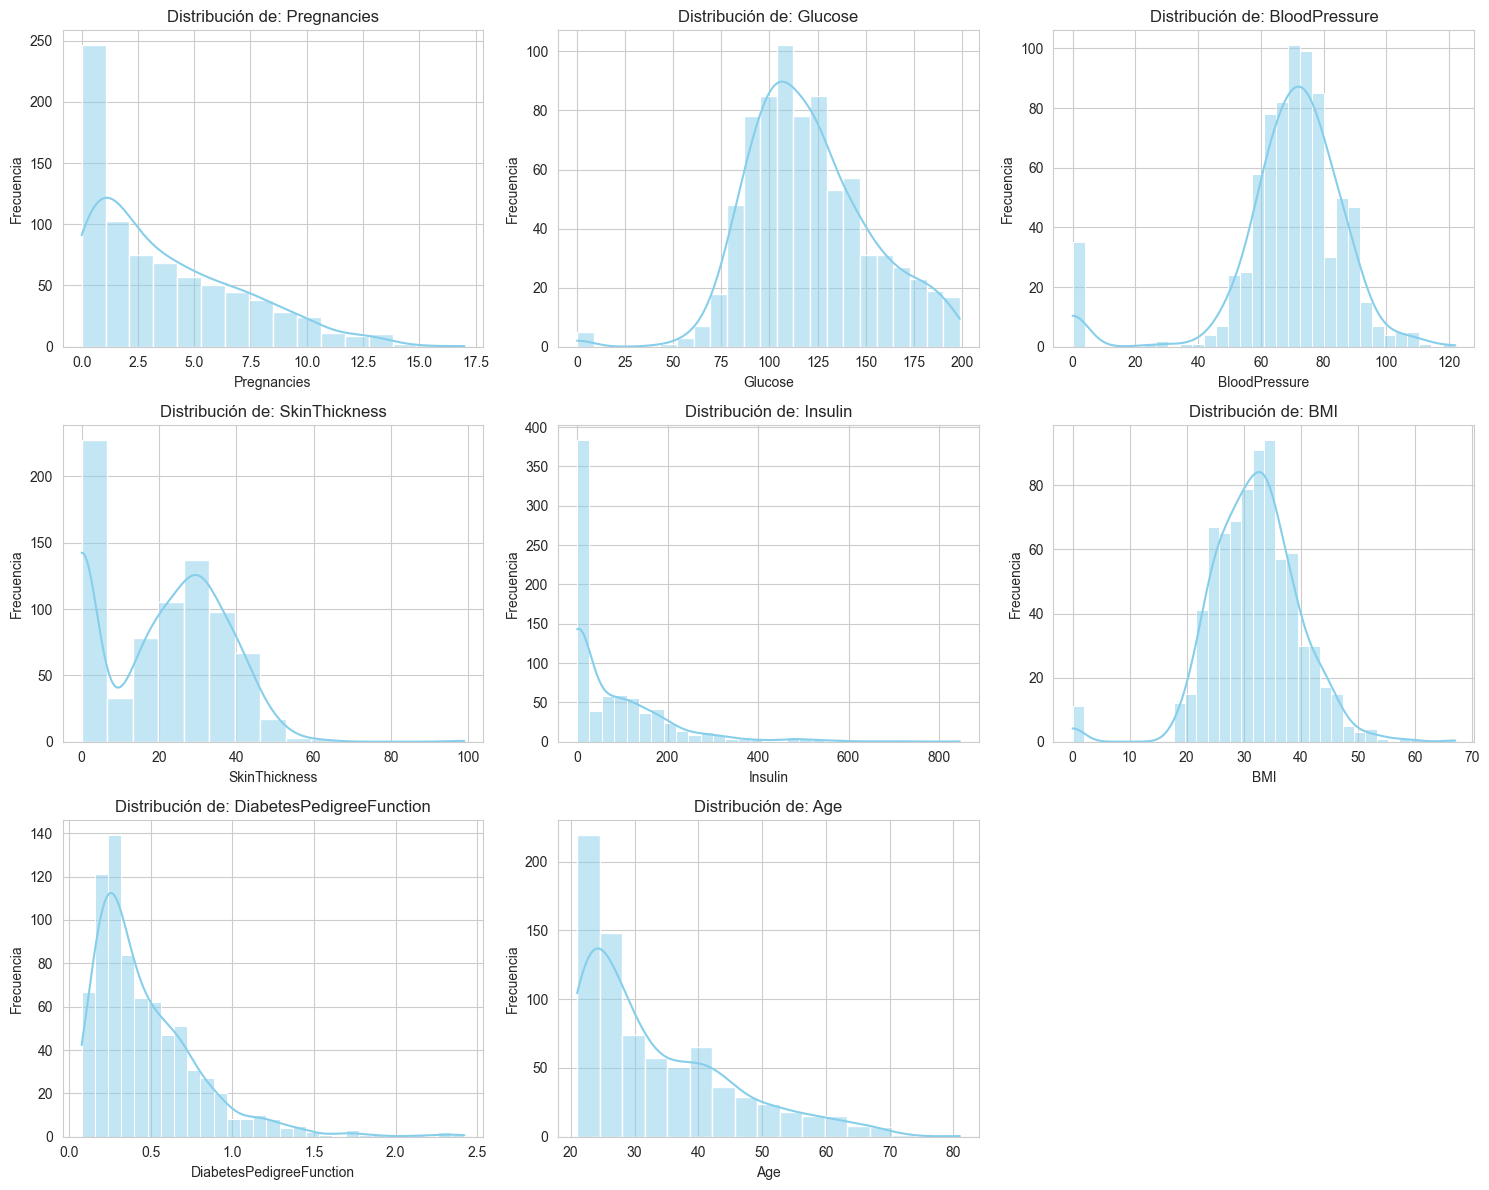

In [5]:

# Excluiremos 'Outcome' ya que es la variable objetivo binaria (0/1)
cols_to_plot = df.drop('Outcome', axis=1).columns
# Configurar el estilo de los gráficos
sns.set_style("whitegrid")

# Crear una figura y subplots (ej. 3 filas y 3 columnas para 9 variables)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten() # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre las columnas y dibujar un histograma en cada eje
for i, col in enumerate(cols_to_plot):
    if i < len(cols_to_plot):
        # Histograma con una curva de densidad (KDE) para suavizar
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Distribución de: {col}', fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Frecuencia', fontsize=10)

# Ocultar cualquier subplot no utilizado si el número de variables no es un cuadrado perfecto
for j in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Ajustar automáticamente los parámetros para que los subplots encajen
plt.show()

En la celda anterior se muestran las gráficas de cada variable donde se puede observar la distribución que poseen los datos. Aunque variables que muestran una distribución normal (BMI, glucose y blood Preasure), el resto tiende mayormente hacia la izquierda, eso es un signo de desbalanceo de datos. 

La distribución de los datos es importante ya que hay modelos que asumen que los datos poseen una distribución normal, por ello, es posible que para este dataset algunos modelos funcionen peor, por ejemplo regresión logistica.

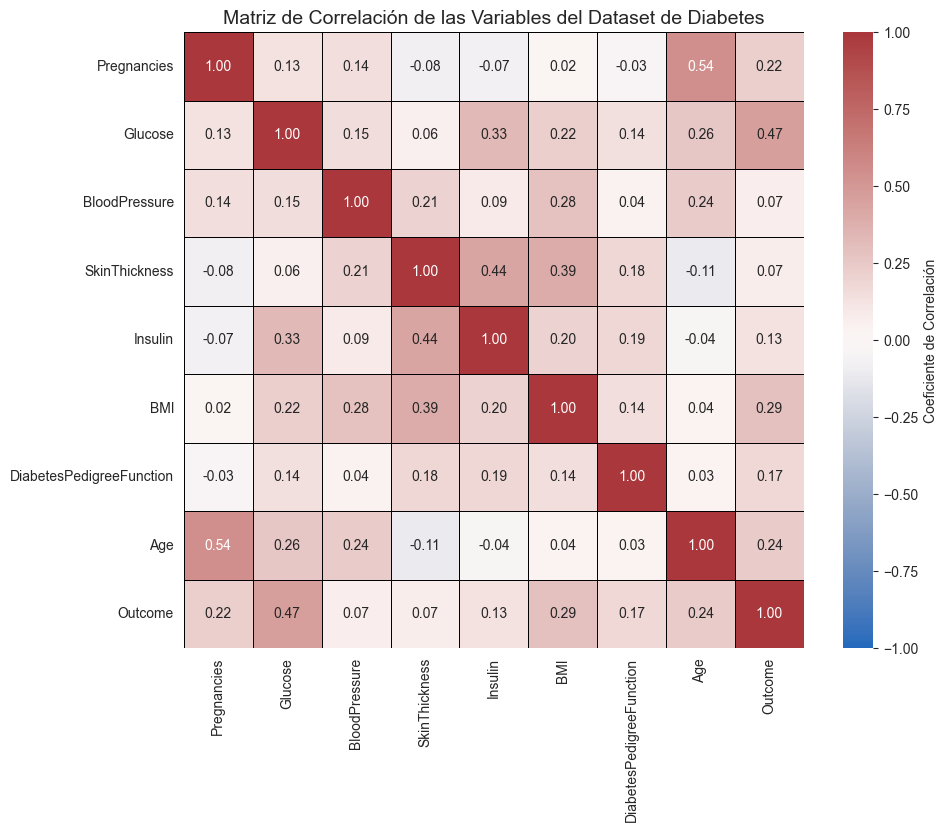

In [6]:
# Usamos el método 'pearson' para correlación lineal
correlation_matrix = df.corr(method='pearson')
plt.figure(figsize=(10, 8))
# Usamos un mapa de calor (heatmap) para visualizar los valores de correlación
sns.heatmap(
    correlation_matrix,
    annot=True,         # Mostrar los valores numéricos de correlación
    fmt=".2f",          # Formato de dos decimales
    cmap='vlag',        # Esquema de color divergente (mejor para correlación)
    vmin=-1, vmax=1,    # Establecer el rango de color de -1 a 1
    linewidths=.5,      # Líneas entre las celdas
    linecolor='black',
    cbar_kws={'label': 'Coeficiente de Correlación'}
)

plt.title('Matriz de Correlación de las Variables del Dataset de Diabetes', fontsize=14)
plt.show()

En la celda anterior calculamos la matriz de correlación de las variables todas con todas. La matriz nos muestra mediante colores como de relacionadas están las variables entre sí. Aquí podemos sacar algunas conclusiones de primeras.

Si nos fijamos en nuestra variable a predecir, Outcome, podemos ver que variables tienen una mayor relación
- Glucose (0.47): Tiene la correlación más alta con el resultado. A mayor glucosa, mayor probabilidad de diabetes. Esto confirma que es la variable más importante del dataset.
- BMI (0.29): El Índice de Masa Corporal es el segundo factor más influyente.
- Age (0.24): La edad también juega un papel relevante.

Si nos fijamos en las variables que mayor relación tienen entre sí, tenemos lo siguiente:
- Pregnancies vs. Age (0.54): Es la correlación más fuerte de todo el gráfico. Tiene sentido lógico: a más edad, una mujer ha tenido más tiempo para tener más embarazos.
- Insulin vs. SkinThickness (0.44): Existe una relación moderada. Esto indica que el grosor del pliegue cutáneo está relacionado con la grasa corporal, lo que a su vez afecta la resistencia a la insulina.

A partir de esta información podríamos evaluar si skin thickness y blood pressure, valores cercanos a 0, podrían ser suprimidos para el entrenamiento del modelo o no. Ya que si tenemos variables que no aportan valor para entrenar, lo que ocurrirá es que el modelo no será capaz de clasificar correctamente al poseer ruido en los datos.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Definir características (X) y variable objetivo (y)
X = df.drop('Outcome', axis=1) # El 'Outcome' es la etiqueta a predecir
y = df['Outcome']

# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2002)

# 1. Imputación (Rellenar NaN con la media)
# Usaremos la media (mean) de cada columna para rellenar los valores NaN.
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Entrenar el Imputer solo con los datos de entrenamiento
X_train_imputed = imputer.fit_transform(X_train)
# Aplicar el Imputer a los datos de prueba
X_test_imputed = imputer.transform(X_test)

# Diccionario para guardar los modelos y sus resultados
models = {
    "Regresión Logística": LogisticRegression(random_state=42, max_iter=200),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Máquina de Vectores de Soporte (SVC)": SVC(random_state=42),
    "Bosques Aleatorios": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
results = {}
print("\n--- Resultados de los Modelos (Accuracy Score) ---")

# Iterar sobre cada modelo para entrenar y evaluar
for name, model in models.items():
    # Entrenar el modelo (usando los datos escalados/imputados)
    model.fit(X_train_imputed, y_train)
    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_imputed)
    # Calcular la precisión (Accuracy Score)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"**{name}**: {accuracy:.4f}")

# Encontrar el mejor modelo
best_model = max(results, key=results.get)

print(f"\n🏆 **El Mejor Modelo fue el de {best_model} con una precisión de {results[best_model]:.4f}**")


--- Resultados de los Modelos (Accuracy Score) ---
**Regresión Logística**: 0.8182
**Árbol de Decisión**: 0.7208
**Máquina de Vectores de Soporte (SVC)**: 0.8052
**Bosques Aleatorios**: 0.8247
**XGBoost**: 0.7208
**K-Nearest Neighbors**: 0.7013

🏆 **El Mejor Modelo fue el de Bosques Aleatorios con una precisión de 0.8247**


d:\UEX\6\SI\PR2\entornoPractica\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:08:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


En la celda anterior hemos preparado cuales son las features para entrenar los modelos y cuales es la variable a predecir, además se ha realizado una imputación de los missing values con simpleImputer que rellenan los datos que faltan, usando el valor medio de la columna. A continuación vamos a comprobar a quitar las columnas mencionadas anteriormente para comprobar que resultados se obtienen.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Definir características (X) y variable objetivo (y)
columns_to_drop = ['Outcome', 'SkinThickness', 'BloodPressure']
# El argumento 'axis=1' es crucial para indicar que eliminamos columnas.
X = df.drop(columns=columns_to_drop, axis=1)

y = df['Outcome']

# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2002)


imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Entrenar el Imputer solo con los datos de entrenamiento
X_train_imputed = imputer.fit_transform(X_train)
# Aplicar el Imputer a los datos de prueba
X_test_imputed = imputer.transform(X_test)

# Diccionario para guardar los modelos y sus resultados
models = {
    "Regresión Logística": LogisticRegression(random_state=42, max_iter=200),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Máquina de Vectores de Soporte (SVC)": SVC(random_state=42),
    "Bosques Aleatorios": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
results = {}
print("\n--- Resultados de los Modelos (Accuracy Score) ---")

# Iterar sobre cada modelo para entrenar y evaluar
for name, model in models.items():
    # Entrenar el modelo (usando los datos escalados/imputados)
    model.fit(X_train_imputed, y_train)
    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_imputed)
    # Calcular la precisión (Accuracy Score)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"**{name}**: {accuracy:.4f}")

# Encontrar el mejor modelo
best_model = max(results, key=results.get)

print(f"\n🏆 **El Mejor Modelo fue el de {best_model} con una precisión de {results[best_model]:.4f}**")


--- Resultados de los Modelos (Accuracy Score) ---
**Regresión Logística**: 0.8117
**Árbol de Decisión**: 0.7403
**Máquina de Vectores de Soporte (SVC)**: 0.7987
**Bosques Aleatorios**: 0.8052
**XGBoost**: 0.7208
**K-Nearest Neighbors**: 0.7468

🏆 **El Mejor Modelo fue el de Regresión Logística con una precisión de 0.8117**


d:\UEX\6\SI\PR2\entornoPractica\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:08:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Podemos observar que no hay grandes diferencias, para algunos modelos hay una pequeña mejoría y para otros empeora ligeramente. Como no hay grandes cambios en el Score no podemos sacar conclusiones y mantenemos por ahora esas columnas en el dataset.

A continuación, intentaremos mejorar los resultados obtenidos, para ello aplicaremos, en primer lugar una técnica de estandarizacion StandardScaler. Y posteriormente aplicaremos GridSearch y validación cruzada para entrenar los modelos y evaluaremos los resultados obtenidos.

In [22]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from missforest.missforest import MissForest
from sklearn.preprocessing import MinMaxScaler

# 1. Cargar datos
# df = pd.read_csv('diabetes.csv')

# 2. DEFINIR LAS COLUMNAS CORRUPTAS (Las que tienen 0s falsos)
# NO incluimos 'Pregnancies' ni 'Outcome'
cols_con_ceros_invalidos = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Ceros antes de limpiar:")
print((df[cols_con_ceros_invalidos] == 0).sum())

# 3. REEMPLAZAR 0 por NaN
# Esto le dice a Python: "Oye, esto no es un número, es un dato faltante"
df[cols_con_ceros_invalidos] = df[cols_con_ceros_invalidos].replace(0, np.nan)

print("\nNaNs (Nulls) después de limpiar (listos para MissForest):")
print(df[cols_con_ceros_invalidos].isnull().sum())


# Instanciar el imputador
#mf = MissForest(categorical=categorical)
mf = MissForest(verbose=True)

# Imputar los datos faltantes
df_imp = mf.fit_transform(df)

# Estandarizamos los datos  con standardScaler
scaler = MinMaxScaler()


columnas_dropeadas =['Outcome','SkinThickness','BloodPressure']
# 4. División Train/Test (Estratificada)
df_train = df_imp.drop(columnas_dropeadas, axis=1)
df_train_scaled = scaler.fit_transform(df_train)
X = df_train_scaled
y = df_imp['Outcome']




X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2002, stratify=y
)

print("\n✅ Datos corregidos e imputados con MissForest.")

Ceros antes de limpiar:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

NaNs (Nulls) después de limpiar (listos para MissForest):
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


100%|██████████| 5/5 [00:00<00:00, 43.64it/s]


✅ Datos corregidos e imputados con MissForest.


A continuación, preparamos el conjunto de train y de test con un 80% de train y un 20% de test. AL ver el número de elementos que tenemos en cada categoría podemos vislumbrar lo que va a pasar. Los datos están desbalanceados. Esto quiere decir que una de las dos clases posee más muestras que la otra. Esto provocará que los modelos normalmente no sean capaces de predecir la clase minoritaria. 

A parte de eso es importante destacar que hemos aplicado el parametro stratify, esto hace que se dividan las clases equitativamente en train y test, es decir que haya proporcionalmente el mismo número de positivos y negativos.



In [23]:
random_state = 2002
# Definir modelos y sus grids de hiperparámetros
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31, 51, 75, 101, 151, 201],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=random_state),
        'params': {
            'penalty': ['l2', None],
            'C': [0.001,0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['lbfgs', 'saga', 'newton-cg','sag'],
            'class_weight': [None, 'balanced']

        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=random_state),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None,10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [ 'sqrt', 'log2'],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=random_state),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [None, 10, 20, 30, 50],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 10],
            'max_features': [None, 'sqrt', 'log2'],
            'splitter': ['best', 'random'],
            'class_weight': [None, 'balanced']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=random_state),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [1, 1.5],
            'scale_pos_weight': [1, 5, 10]
        }
    }
    }


# Mi ejecución optimizada.
---
A continuación hemos definimos los modelos y sus parametros que vamos a evaluar con GridSearch.

🔥 Iniciando entrenamiento y optimización de múltiples modelos de clasificación...

🤖 Entrenando KNN...
Fitting 5 folds for each of 208 candidates, totalling 1040 fits
✅ KNN completado
   📈 Train - Acc: 1.0000, F1: 1.0000
   🎯 Test  - Acc: 0.7468, F1: 0.7437

🤖 Entrenando LogisticRegression...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


d:\UEX\6\SI\PR2\entornoPractica\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


✅ LogisticRegression completado
   📈 Train - Acc: 0.7541, F1: 0.7571
   🎯 Test  - Acc: 0.7727, F1: 0.7770

🤖 Entrenando RandomForest...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
✅ RandomForest completado
   📈 Train - Acc: 0.8876, F1: 0.8892
   🎯 Test  - Acc: 0.7468, F1: 0.7511

🤖 Entrenando DecisionTree...
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
✅ DecisionTree completado
   📈 Train - Acc: 0.8469, F1: 0.8498
   🎯 Test  - Acc: 0.7208, F1: 0.7242

🤖 Entrenando XGBoost...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
✅ XGBoost completado
   📈 Train - Acc: 0.9088, F1: 0.9106
   🎯 Test  - Acc: 0.7338, F1: 0.7397

📊 COMPARACIÓN DE RESULTADOS - TRAIN vs TEST
            Modelo  Acc_Train  Acc_Test  F1_Train  F1_Test  Precision_Train  Precision_Test  Recall_Test
LogisticRegression   0.754072  0.772727  0.757073 0.777036         0.763002        0.792292     0.772727
               KNN   1.000000  0.746753  1.000000 0.743695       

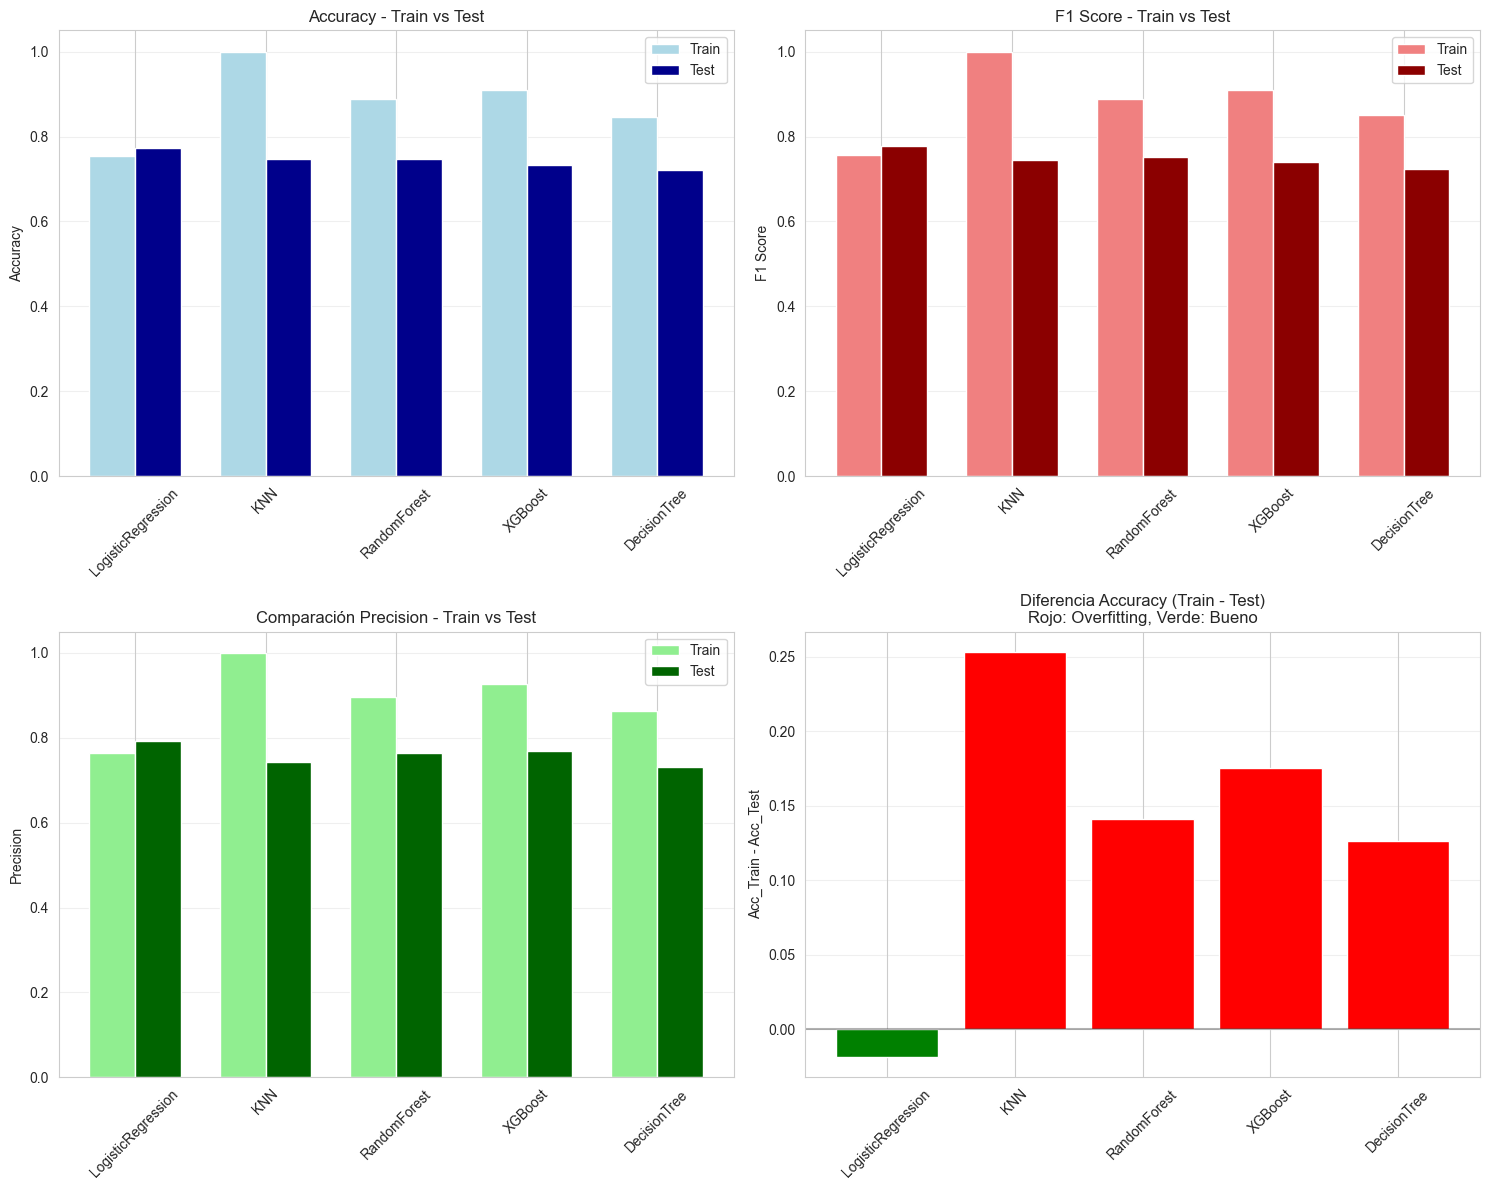

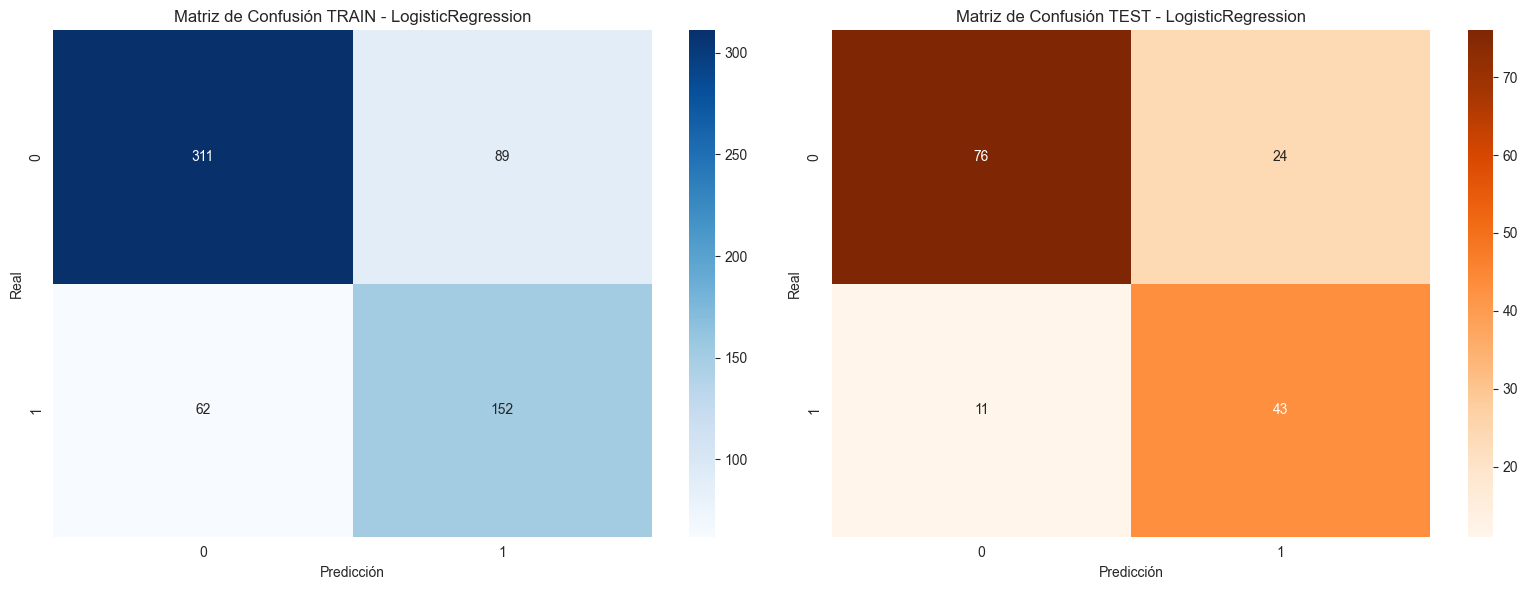

In [24]:
import os
import joblib
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from xgboost import cv

results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
print("🔥 Iniciando entrenamiento y optimización de múltiples modelos de clasificación...")
print("="*70)
classes = sorted(y.unique())  # [0, 1, 2, 3]

for name, config in models.items():
    print(f"\n🤖 Entrenando {name}...")
    
    # GridSearchCV para todos los modelos
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=skf,
        scoring='f1',
        n_jobs=8,
        verbose=1
    )
        # Entrenar con datos resampled
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    y_pred_train = best_model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
    cm_train = confusion_matrix(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train)


    y_pred_test = best_model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
    cm_test = confusion_matrix(y_test, y_pred_test)
    report_test = classification_report(y_test, y_pred_test)

    # Guardar modelo
    model_path = os.path.join( f"{name}_classifier_modelo.joblib")
    joblib.dump(best_model, model_path)

    # Almacenar resultados
    results[name] = {
        'best_params': grid.best_params_,
        'acc_cv': grid.best_score_,
        'acc_train': acc_train,
        'precision_train': precision_train,
        'recall_train': recall_train,
        'f1_train': f1_train,
        'acc_test': acc_test,
        'precision_test': precision_test,
        'recall_test': recall_test,
        'f1_test': f1_test,
        'classification_report_train': report_train,
        'classification_report_test': report_test,
        'confusion_matrix_train': cm_train,
        'confusion_matrix_test': cm_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'model': best_model
    }

    print(f"✅ {name} completado")
    print(f"   📈 Train - Acc: {acc_train:.4f}, F1: {f1_train:.4f}")
    print(f"   🎯 Test  - Acc: {acc_test:.4f}, F1: {f1_test:.4f}")

# Comparación de resultados
comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Acc_Train': [results[name]['acc_train'] for name in results.keys()],
    'Acc_Test': [results[name]['acc_test'] for name in results.keys()],
    'F1_Train': [results[name]['f1_train'] for name in results.keys()],
    'F1_Test': [results[name]['f1_test'] for name in results.keys()],
    'Precision_Train': [results[name]['precision_train'] for name in results.keys()],
    'Precision_Test': [results[name]['precision_test'] for name in results.keys()],
    'Recall_Test': [results[name]['recall_test'] for name in results.keys()]
}).sort_values('Acc_Test', ascending=False)

print("\n" + "="*70)
print("📊 COMPARACIÓN DE RESULTADOS - TRAIN vs TEST")
print("="*70)
print(comparison_df.to_string(index=False))

# ✅ GRÁFICOS COMPARATIVOS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

x = np.arange(len(comparison_df))
width = 0.35

# Accuracy Train vs Test
ax1.bar(x - width/2, comparison_df['Acc_Train'], width, label='Train', color='lightblue')
ax1.bar(x + width/2, comparison_df['Acc_Test'], width, label='Test', color='darkblue')
ax1.set_title('Accuracy - Train vs Test')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# F1 Score Train vs Test
ax2.bar(x - width/2, comparison_df['F1_Train'], width, label='Train', color='lightcoral')
ax2.bar(x + width/2, comparison_df['F1_Test'], width, label='Test', color='darkred')
ax2.set_title('F1 Score - Train vs Test')
ax2.set_ylabel('F1 Score')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Precision Train vs Test
ax3.bar(x - width/2, comparison_df['Precision_Train'], width, label='Train', color='lightgreen')
ax3.bar(x + width/2, comparison_df['Precision_Test'], width, label='Test', color='darkgreen')
ax3.set_title('Comparación Precision - Train vs Test')
ax3.set_ylabel('Precision')
ax3.set_xticks(x)
ax3.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Overfitting detection
acc_diff = comparison_df['Acc_Train'] - comparison_df['Acc_Test']
colors = ['red' if diff > 0.1 else 'orange' if diff > 0.05 else 'green' for diff in acc_diff]
ax4.bar(comparison_df['Modelo'], acc_diff, color=colors)
ax4.set_title('Diferencia Accuracy (Train - Test)\nRojo: Overfitting, Verde: Bueno')
ax4.set_ylabel('Acc_Train - Acc_Test')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ✅ MATRICES DE CONFUSIÓN del mejor modelo (TRAIN y TEST)
best_model_name = comparison_df.iloc[0]['Modelo']
best_cm_train = results[best_model_name]['confusion_matrix_train']
best_cm_test = results[best_model_name]['confusion_matrix_test']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión TRAIN
sns.heatmap(best_cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=ax1)
ax1.set_xlabel("Predicción")
ax1.set_ylabel("Real")
ax1.set_title(f'Matriz de Confusión TRAIN - {best_model_name}')

# Matriz de confusión TEST
sns.heatmap(best_cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=classes, yticklabels=classes, ax=ax2)
ax2.set_xlabel("Predicción")
ax2.set_ylabel("Real")
ax2.set_title(f'Matriz de Confusión TEST - {best_model_name}')

plt.tight_layout()
plt.show()

Este fragmento de código lo he extraído de la elaboración de mi TFG. En él, se realiza un bucle que entrena los modelos con todas las combinaciones de parametros que hemos definido previamente. Además se realiza un cross Validation de 5 folds o pliegues. Además se define como método de evaluación de los modelos o scoring el F1-score. Tambien paralelizamos el entrenamiento de los modelos con 8 procesos, tal y como definimos en n_jobs. Para este caso concreto, he de destacar el uso de lo siguiente:

-  Por un lado, he utilizado stratified K fold para poder paliar los efectos del desbalanceo del dataset, en lugar de usar K-fold convencional.
-  Además, he introducido parametros a algunos modelos como class_weight, para que los modelos no tiendan a clasificar las muestras en la clase mayoritaria.
-  Se usa un 20 % de test.


Una vez ejecutado el script se pintan las gráficas donde se muestra: 
- Accuracy en train vs test.
- F1-scorre en train vs test.
- Precision en train vs test.
- Diferencia de Accuracy entre train y test. (Nos sirve para detectar overfitting.)

Por último, se muestra la matriz de confusión del que se determina como el mejor modelo, en train y test.


In [26]:
print (f"\n🏆 Mejor Modelo: {best_model_name}")
comparison_df.head(n=5)


🏆 Mejor Modelo: LogisticRegression


,Modelo,Acc_Train,Acc_Test,F1_Train,F1_Test,Precision_Train,Precision_Test,Recall_Test
1,LogisticRegression,0.754072,0.772727,0.757073,0.777036,0.763002,0.792292,0.772727
0,KNN,1.000000,0.746753,1.000000,0.743695,1.000000,0.742292,0.746753
2,RandomForest,0.887622,0.746753,0.889152,0.751088,0.895326,0.762990,0.746753
4,XGBoost,0.908795,0.733766,0.910639,0.739708,0.927711,0.767714,0.733766
3,DecisionTree,0.846906,0.720779,0.849809,0.724214,0.863996,0.730610,0.720779


# Logistic Regresion es el mejor modelo.

Modelos Basados en Instancias y Árboles (KNN, Random Forest, XGBoost): Mostraron un sobreajuste (overfitting) severo.

- KNN alcanzó una exactitud perfecta en entrenamiento (~1.0), pero cayó drásticamente en test (~0.75), evidenciando una memorización del ruido.
- Random Forest y XGBoost, a pesar de la regularización, mantuvieron una brecha de exactitud entre train y test superior al 10-15% (barras rojas en el gráfico de "Diferencia Accuracy").

Modelos Lineales (Logistic Regression):

- Fue el único modelo que generalizó correctamente, mostrando incluso un ligero "underfitting" positivo (barra verde en diferencia de accuracy).
- Su exactitud en Test (~0.77) fue superior a su exactitud en Train (~0.76), indicando robustez ante datos no vistos.

Respecto a la matriz de confusión:

- En el conjunto de Test, el modelo ha logrado identificar correctamente a 43 de los 54 pacientes que realmente tenían diabetes. Esto representa una Sensibilidad del ~80% ($43/54$). Por lo que el modelo cumple bien su función principal médica, no dejar escapar a los enfermos. Solo ha fallado en 11 casos (Falsos Negativos), lo cual es una cifra baja considerando la dificultad del dataset.

- El modelo genera un número considerable de Falsos Positivos. En Test, ha etiquetado como diabéticos a 24 personas que estaban sanas. De todas las veces que el modelo gritó "¡Diabetes!" (24 + 43 = 67), solo acertó el 64% de las veces.
Conclusión: Es un modelo "conservador" o de "cribado". Prefiere pecar de precavido y asustar a un paciente sano (para que luego se haga más pruebas) antes que mandar a casa a un enfermo sin diagnosticar. 

- Además, el hecho de que el rendimiento en Test sea incluso ligeramente superior (o muy estable) respecto a Train confirma que el modelo no ha memorizado los datos. La Regresión Logística ha aprendido un patrón generalizable y sólido.


In [27]:

print(" COMPARACIÓN DE RESULTADOS ALMACENADOS DE MAYOR A MENOR SCORE")
print("="*70)
print(comparison_df.to_string(index=False))

 COMPARACIÓN DE RESULTADOS ALMACENADOS DE MAYOR A MENOR SCORE
            Modelo  Acc_Train  Acc_Test  F1_Train  F1_Test  Precision_Train  Precision_Test  Recall_Test
LogisticRegression   0.754072  0.772727  0.757073 0.777036         0.763002        0.792292     0.772727
               KNN   1.000000  0.746753  1.000000 0.743695         1.000000        0.742292     0.746753
      RandomForest   0.887622  0.746753  0.889152 0.751088         0.895326        0.762990     0.746753
           XGBoost   0.908795  0.733766  0.910639 0.739708         0.927711        0.767714     0.733766
      DecisionTree   0.846906  0.720779  0.849809 0.724214         0.863996        0.730610     0.720779


In [28]:
print(f"\n📄 REPORTE DE CLASIFICACIÓN DETALLADO para: {best_model_name}")
print("="*50)
print(results[best_model_name]['classification_report_test'])


📄 REPORTE DE CLASIFICACIÓN DETALLADO para: LogisticRegression
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       100
           1       0.64      0.80      0.71        54

    accuracy                           0.77       154
   macro avg       0.76      0.78      0.76       154
weighted avg       0.79      0.77      0.78       154



## Métricas de Evaluación del Modelo

### Accuracy (Exactitud Global): **0.77**

- **Definición:** Representa el porcentaje total de aciertos (tanto sanos como enfermos) sobre el total de muestras.
- **Resultado:** El modelo clasifica correctamente al 77% de los pacientes. Es una cifra sólida, superior a la línea base, indicando que el modelo ha aprendido patrones generalizables y no está adivinando al azar.


### Recall (Sensibilidad) - Clase 1 (Diabetes): **0.80**

- **Definición:** Mide la capacidad del modelo para detectar los casos positivos reales. Responde a: "De todos los diabéticos que hay, ¿cuántos hemos encontrado?".
- **Resultado:** El modelo alcanza un 80%. Esta es la métrica más crítica en el ámbito médico. Significa que el sistema es capaz de detectar a la gran mayoría de los pacientes enfermos, dejando escapar (Falsos Negativos) solo al 20%, lo cual lo hace muy útil para tareas de cribado (*screening*).


### Precision (Precisión) - Clase 1 (Diabetes): **0.64**

- **Definición:** Mide la fiabilidad de las predicciones positivas. Responde a: "Cuando el modelo dice que alguien tiene diabetes, ¿qué probabilidad hay de que sea verdad?".
- **Resultado:** Con un 64%, el modelo es algo conservador. Acepta generar un número moderado de Falsos Positivos (pacientes sanos etiquetados erróneamente como enfermos) a cambio de mantener alto el Recall. En medicina, esto es aceptable, ya que es preferible una falsa alarma a un diagnóstico perdido.


### F1-Score - Clase 1 (Diabetes): **0.71**

- **Definición:** Es la media armónica entre Precision y Recall. Ofrece una visión única del equilibrio del modelo.
- **Resultado:** Un 0.71 indica que el modelo mantiene un buen compromiso entre detectar enfermos y no generar excesivo ruido. No está sesgado hacia ninguna clase extrema, validando la eficacia del parámetro `class_weight='balanced'`.


## Conclusión del Modelo

La Regresión Logística presenta el perfil ideal para una herramienta de apoyo al diagnóstico: prioriza la detección de la enfermedad (Alto Recall) manteniendo una exactitud global competente, evitando el sobreajuste que mostraron modelos más complejos.

A continuación se pinta la ROC

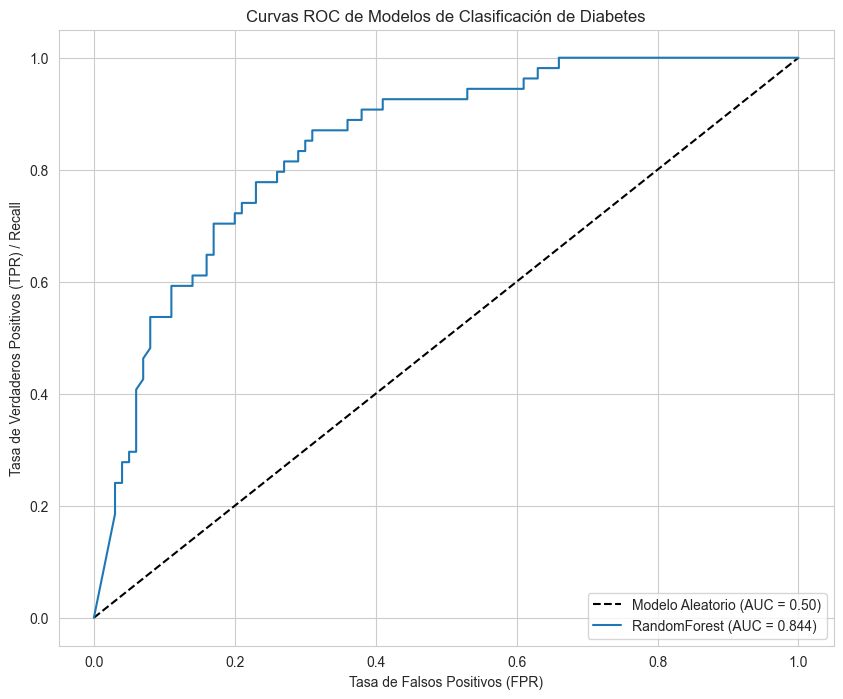

In [57]:
from sklearn.metrics import roc_curve, auc

# Necesitas estas librerías que ya tienes importadas
# import pandas as pd 
# import seaborn as sns
# --- 1. Inicializar la Figura ---
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio (AUC = 0.50)') # Línea de referencia


    
# 2.1. Obtener el modelo y los datos de prueba
best_model = results[best_model_name]['model']
name = best_model_name

# NOTA: Debes usar los datos de prueba preprocesados (escalados/imputados) 
# Asegúrate de que X_test_scaled está disponible en este scope.
# Si no tienes X_test_scaled, necesitarás cargarlo. Usaremos X_test por defecto.

# Intenta obtener las probabilidades de la clase positiva (1)
try:
    # Algunos modelos usan decision_function (SVC, Regresión Logística, etc.)
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test)
    else:
        # Si el modelo no tiene método de probabilidad/decisión (ej. KNN)
        print(f"Advertencia: El modelo {name} no tiene predict_proba o decision_function.")
        
        
except Exception as e:
    print(f"Error al obtener scores para {name}: {e}")
    

# 2.2. Calcular la Tasa de Falsos Positivos (FPR) y Verdaderos Positivos (TPR)
# y_test debe ser la variable objetivo real para el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# 2.3. Calcular el Área Bajo la Curva (AUC)
roc_auc = auc(fpr, tpr)

# 2.4. Plotear la curva
plt.plot(
    fpr, 
    tpr, 
    label=f'{name} (AUC = {roc_auc:.3f})'
)

# --- 3. Personalizar la Gráfica ---
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curvas ROC de Modelos de Clasificación de Diabetes')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Aplicando resampling.
---
A continuación intentaré aplicar técnicas de resampling para intentar balancear los datos. A la hora de importar las librerías de imblearn, obtenía un fallo porque tengo instalado las últimas versiones de scikit y pandas. imblearn necesita unos métodos de scikit que la versión moderna no posee. Por lo que para poder probar el resampling he tenido que declarar los métodos yo mismo y evitar el paralelismo a la hora de entrenar los modelos porque tambien fallaba. Todo esto para obtener resultados malos...

✅ Parches de sistema aplicados correctamente.

📊 Distribución Original Train: Counter({np.int64(0): 400, np.int64(1): 214})
⚖️ Aplicando SMOTE-ENN (Creando sintéticos + Limpiando ruido)...
📊 Distribución Resampled Train: Counter({np.int64(1): 260, np.int64(0): 219})
   Tamaño: 614 -> 479 filas.

🔥 Iniciando entrenamiento y optimización de modelos con datos balanceados...

🤖 Entrenando KNN...
Fitting 5 folds for each of 208 candidates, totalling 1040 fits
✅ KNN completado
   📈 Train (Resampled) - F1: 1.0000
   🎯 Test (Original)   - F1: 0.7314

🤖 Entrenando LogisticRegression...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


d:\UEX\6\SI\PR2\entornoPractica\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\UEX\6\SI\PR2\entornoPractica\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\UEX\6\SI\PR2\entornoPractica\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warn

✅ LogisticRegression completado
   📈 Train (Resampled) - F1: 0.9268
   🎯 Test (Original)   - F1: 0.7059

🤖 Entrenando RandomForest...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
✅ RandomForest completado
   📈 Train (Resampled) - F1: 1.0000
   🎯 Test (Original)   - F1: 0.7461

🤖 Entrenando DecisionTree...
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
✅ DecisionTree completado
   📈 Train (Resampled) - F1: 0.9581
   🎯 Test (Original)   - F1: 0.7012

🤖 Entrenando XGBoost...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
✅ XGBoost completado
   📈 Train (Resampled) - F1: 1.0000
   🎯 Test (Original)   - F1: 0.7207

📊 COMPARACIÓN DE RESULTADOS (SMOTE-ENN)
            Modelo  Acc_Train  Acc_Test  F1_Train  F1_Test  Precision_Test  Recall_Test
      RandomForest   1.000000  0.740260  1.000000 0.746053        0.793932     0.740260
               KNN   1.000000  0.727273  1.000000 0.731430        0.817614     0.727273
           XGBoost   1.

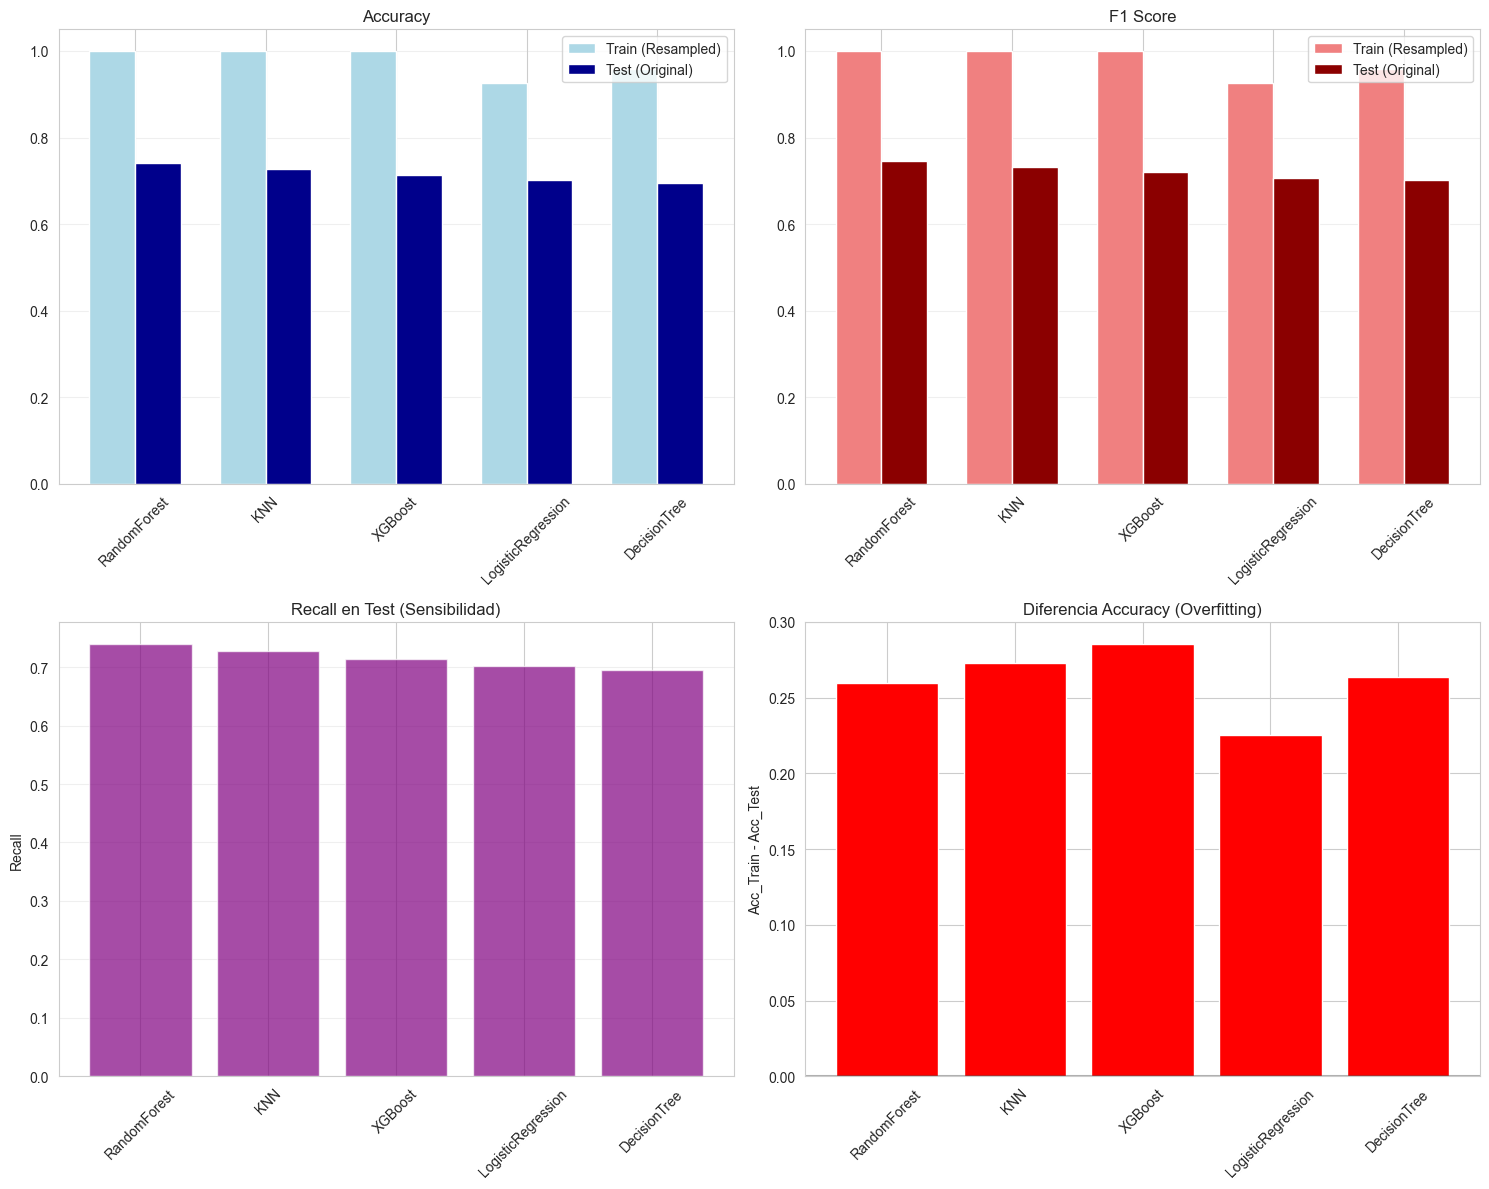

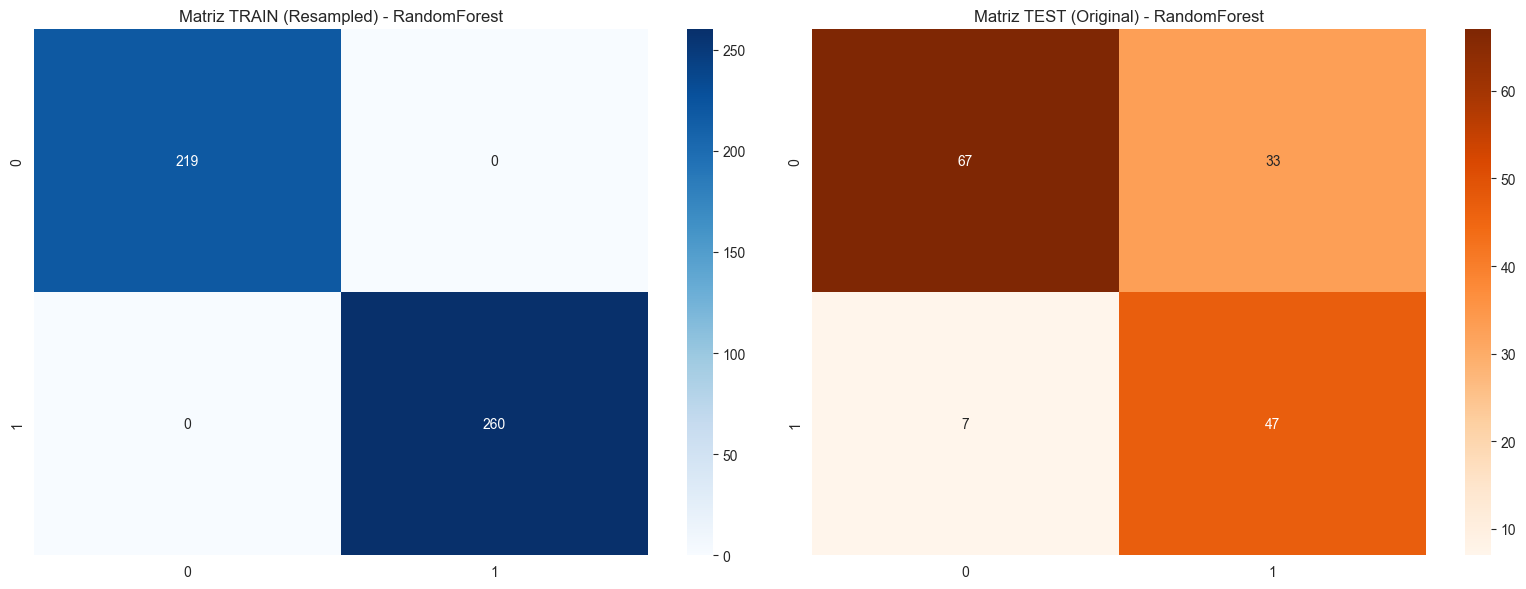

In [52]:
import sys
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.utils.validation
import sklearn.ensemble

# ==============================================================================
# 1. PARCHES DE COMPATIBILIDAD (CRÍTICO PARA TU ENTORNO)
# ==============================================================================
# Parche A: Restaurar _is_pandas_df para imblearn
def _is_pandas_df(x):
    return hasattr(x, "dtypes") and hasattr(x, "columns")
sklearn.utils.validation._is_pandas_df = _is_pandas_df

# Parche B: Arreglar AdaBoost (ignorar parámetro 'algorithm')
_original_init = sklearn.ensemble.AdaBoostClassifier.__init__
def _patched_init(self, *args, **kwargs):
    if 'algorithm' in kwargs: kwargs.pop('algorithm')
    _original_init(self, *args, **kwargs)
sklearn.ensemble.AdaBoostClassifier.__init__ = _patched_init

print("✅ Parches de sistema aplicados correctamente.")

# AHORA IMPORTAMOS LAS LIBRERÍAS DE ML
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

# ==============================================================================
# 2. PREPARACIÓN Y SMOTE-ENN
# ==============================================================================

# Convertimos a arrays de NumPy para evitar errores de índices (.iloc vs [])
# Asumimos que X_train y y_train ya vienen escalados/imputados de pasos anteriores
X_train_clean = np.array(X_train)
y_train_clean = np.array(y_train)
X_test_clean = np.array(X_test)
y_test_clean = np.array(y_test)

print(f"\n📊 Distribución Original Train: {Counter(y_train_clean)}")

# Aplicamos SMOTE-ENN
print("⚖️ Aplicando SMOTE-ENN (Creando sintéticos + Limpiando ruido)...")
smote_enn = SMOTEENN(random_state=2002) # Usamos tu random_state
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_clean, y_train_clean)

print(f"📊 Distribución Resampled Train: {Counter(y_train_resampled)}")
print(f"   Tamaño: {X_train_clean.shape[0]} -> {X_train_resampled.shape[0]} filas.")

# ==============================================================================
# 3. ENTRENAMIENTO (MODIFICADO PARA USAR DATOS RESAMPLED)
# ==============================================================================

results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2002)
classes = np.unique(y_train_clean) # [0, 1]

print("\n🔥 Iniciando entrenamiento y optimización de modelos con datos balanceados...")
print("="*70)

# Asegúrate de que 'models' esté definido antes de esto (tu diccionario de modelos)
# Si no está definido en esta celda, asegúrate de haber corrido la celda anterior donde lo defines.

for name, config in models.items():
    print(f"\n🤖 Entrenando {name}...")
    
    # GridSearchCV
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=skf,
        scoring='f1', # Optimizamos para F1 porque las clases estaban desbalanceadas
        n_jobs=1,
        verbose=1
    )
    
    # --- CAMBIO CLAVE: Entrenamos con los datos de SMOTE-ENN ---
    grid.fit(X_train_resampled, y_train_resampled)
    best_model = grid.best_estimator_
    
    # 1. Evaluación en TRAIN (Usamos resampled para ver qué tal aprendió)
    y_pred_train = best_model.predict(X_train_resampled)
    acc_train = accuracy_score(y_train_resampled, y_pred_train)
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train_resampled, y_pred_train, average='weighted')
    cm_train = confusion_matrix(y_train_resampled, y_pred_train)
    report_train = classification_report(y_train_resampled, y_pred_train)

    # 2. Evaluación en TEST (¡IMPORTANTE! Usamos X_test ORIGINAL, nunca resampleado)
    y_pred_test = best_model.predict(X_test_clean)
    acc_test = accuracy_score(y_test_clean, y_pred_test)
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test_clean, y_pred_test, average='weighted')
    cm_test = confusion_matrix(y_test_clean, y_pred_test)
    report_test = classification_report(y_test_clean, y_pred_test)

    # Guardar modelo
    model_path = os.path.join(f"{name}_classifier_modelo.joblib")
    joblib.dump(best_model, model_path)

    # Almacenar resultados
    results[name] = {
        'best_params': grid.best_params_,
        'acc_cv': grid.best_score_,
        'acc_train': acc_train,
        'precision_train': precision_train,
        'recall_train': recall_train,
        'f1_train': f1_train,
        'acc_test': acc_test,
        'precision_test': precision_test,
        'recall_test': recall_test,
        'f1_test': f1_test,
        'classification_report_train': report_train,
        'classification_report_test': report_test,
        'confusion_matrix_train': cm_train,
        'confusion_matrix_test': cm_test,
        'model': best_model
    }

    print(f"✅ {name} completado")
    print(f"   📈 Train (Resampled) - F1: {f1_train:.4f}")
    print(f"   🎯 Test (Original)   - F1: {f1_test:.4f}")

# ==============================================================================
# 4. VISUALIZACIÓN Y COMPARATIVAS
# ==============================================================================

comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Acc_Train': [results[name]['acc_train'] for name in results.keys()],
    'Acc_Test': [results[name]['acc_test'] for name in results.keys()],
    'F1_Train': [results[name]['f1_train'] for name in results.keys()],
    'F1_Test': [results[name]['f1_test'] for name in results.keys()],
    'Precision_Test': [results[name]['precision_test'] for name in results.keys()],
    'Recall_Test': [results[name]['recall_test'] for name in results.keys()]
}).sort_values('F1_Test', ascending=False) # Ordenamos por F1 en Test

print("\n" + "="*70)
print("📊 COMPARACIÓN DE RESULTADOS (SMOTE-ENN)")
print("="*70)
print(comparison_df.to_string(index=False))

# GRÁFICOS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
x = np.arange(len(comparison_df))
width = 0.35

# Accuracy
ax1.bar(x - width/2, comparison_df['Acc_Train'], width, label='Train (Resampled)', color='lightblue')
ax1.bar(x + width/2, comparison_df['Acc_Test'], width, label='Test (Original)', color='darkblue')
ax1.set_title('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# F1 Score
ax2.bar(x - width/2, comparison_df['F1_Train'], width, label='Train (Resampled)', color='lightcoral')
ax2.bar(x + width/2, comparison_df['F1_Test'], width, label='Test (Original)', color='darkred')
ax2.set_title('F1 Score')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Recall (Importante en medicina)
ax3.bar(comparison_df['Modelo'], comparison_df['Recall_Test'], color='purple', alpha=0.7)
ax3.set_title('Recall en Test (Sensibilidad)')
ax3.set_ylabel('Recall')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Overfitting detection
acc_diff = comparison_df['Acc_Train'] - comparison_df['Acc_Test']
colors = ['red' if diff > 0.1 else 'orange' if diff > 0.05 else 'green' for diff in acc_diff]
ax4.bar(comparison_df['Modelo'], acc_diff, color=colors)
ax4.set_title('Diferencia Accuracy (Overfitting)')
ax4.set_ylabel('Acc_Train - Acc_Test')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# MATRICES DE CONFUSIÓN (Mejor modelo)
best_model_name = comparison_df.iloc[0]['Modelo']
best_cm_train = results[best_model_name]['confusion_matrix_train']
best_cm_test = results[best_model_name]['confusion_matrix_test']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(best_cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax1)
ax1.set_title(f'Matriz TRAIN (Resampled) - {best_model_name}')

sns.heatmap(best_cm_test, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes, ax=ax2)
ax2.set_title(f'Matriz TEST (Original) - {best_model_name}')

plt.tight_layout()
plt.show()

In [53]:
print (f"\n🏆 Mejor Modelo: {best_model_name}")
comparison_df.head(n=5)


🏆 Mejor Modelo: RandomForest


,Modelo,Acc_Train,Acc_Test,F1_Train,F1_Test,Precision_Test,Recall_Test
2,RandomForest,1.000000,0.740260,1.000000,0.746053,0.793932,0.740260
0,KNN,1.000000,0.727273,1.000000,0.731430,0.817614,0.727273
4,XGBoost,1.000000,0.714286,1.000000,0.720658,0.767616,0.714286
1,LogisticRegression,0.926931,0.701299,0.926823,0.705852,0.789529,0.701299
3,DecisionTree,0.958246,0.694805,0.958104,0.701228,0.757150,0.694805


## Análisis del Modelo Random Forest con SMOTE-ENN

### 1. Detección de Diabetes (Clase 1): 

- **Recall (Sensibilidad): 0.87 (MUY ALTO)**
  - **Lo bueno:** El modelo es excelente detectando enfermos. De cada 100 diabéticos reales, atrapa a 87. Solo se le escapan 13.
  - **Comparación:** Supera a la Regresión Logística y a casi cualquier otro modelo estándar en capacidad de detección pura.

- **Precision: 0.59 (BAJO)**
  - **Lo malo:**  De cada 100 personas que el modelo señala como "Diabéticos", solo 59 lo son realmente. Los otros 41 son personas sanas asustadas innecesariamente.



### 2. Detección de Sanos (Clase 0):

- **Recall: 0.67**
  - **Punto débil crítico:** El modelo falla al identificar a los sanos.
  - El 33% de las personas sanas son clasificadas incorrectamente como enfermas. Esto ocurre porque SMOTE-ENN "limpió" tanto los datos de entrenamiento que el modelo olvidó cómo se ven los pacientes sanos "limítrofes" o complejos.



### 3. La Huella del SMOTE-ENN (Interpretación del Fenómeno) 🧬

- Estos números gritan "Distorsión por Resampling":
  - **SMOTE** creó tantos ejemplos sintéticos de diabetes que el Random Forest aprendió a ver diabetes en todas partes.
  - **ENN** borró a los sanos que se parecían un poco a los enfermos.
- **Resultado:** El modelo trazó una frontera muy agresiva. Ante la mínima duda, clasifica como "Diabetes".



### 4. Accuracy Global (0.74) vs. Utilidad Médica ⚖️

- Aunque el Accuracy (74%) parece bajo comparado con otros modelos (que rondaban el 77%), este modelo tiene una utilidad muy específica:

 La implementación de Random Forest con SMOTE-ENN ha generado un modelo de alto cribado (*High Recall Screening*). Con una sensibilidad del 87%, es la mejor herramienta para asegurar que ningún enfermo se vaya a casa sin diagnóstico. Sin embargo, su alta tasa de Falsos Positivos (baja Precisión del 59%) lo hace inviable como herramienta de diagnóstico final, requiriendo obligatoriamente una segunda prueba confirmatoria para descartar a los sanos mal clasificados.

In [54]:
print(f"\n📄 REPORTE DE CLASIFICACIÓN DETALLADO para: {best_model_name}")
print("="*50)
print(results[best_model_name]['classification_report_test'])


📄 REPORTE DE CLASIFICACIÓN DETALLADO para: RandomForest
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       100
           1       0.59      0.87      0.70        54

    accuracy                           0.74       154
   macro avg       0.75      0.77      0.74       154
weighted avg       0.79      0.74      0.75       154



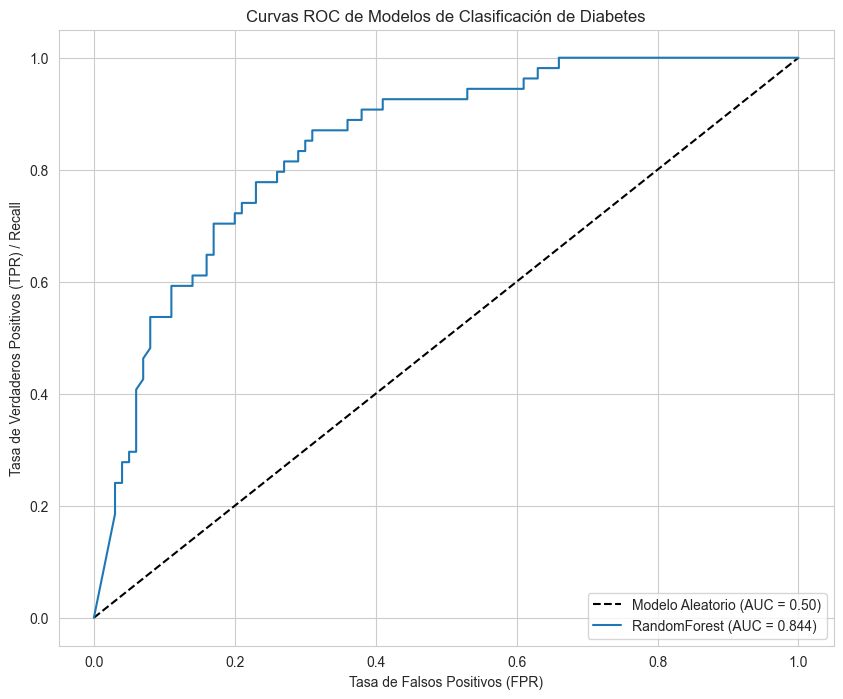

In [55]:
from sklearn.metrics import roc_curve, auc

# Necesitas estas librerías que ya tienes importadas
# import pandas as pd 
# import seaborn as sns
# --- 1. Inicializar la Figura ---
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio (AUC = 0.50)') # Línea de referencia


    
# 2.1. Obtener el modelo y los datos de prueba
best_model = results[best_model_name]['model']
name = best_model_name

# NOTA: Debes usar los datos de prueba preprocesados (escalados/imputados) 
# Asegúrate de que X_test_scaled está disponible en este scope.
# Si no tienes X_test_scaled, necesitarás cargarlo. Usaremos X_test por defecto.

# Intenta obtener las probabilidades de la clase positiva (1)
try:
    # Algunos modelos usan decision_function (SVC, Regresión Logística, etc.)
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test)
    else:
        # Si el modelo no tiene método de probabilidad/decisión (ej. KNN)
        print(f"Advertencia: El modelo {name} no tiene predict_proba o decision_function.")
        
        
except Exception as e:
    print(f"Error al obtener scores para {name}: {e}")
    

# 2.2. Calcular la Tasa de Falsos Positivos (FPR) y Verdaderos Positivos (TPR)
# y_test debe ser la variable objetivo real para el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# 2.3. Calcular el Área Bajo la Curva (AUC)
roc_auc = auc(fpr, tpr)

# 2.4. Plotear la curva
plt.plot(
    fpr, 
    tpr, 
    label=f'{name} (AUC = {roc_auc:.3f})'
)

# --- 3. Personalizar la Gráfica ---
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curvas ROC de Modelos de Clasificación de Diabetes')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



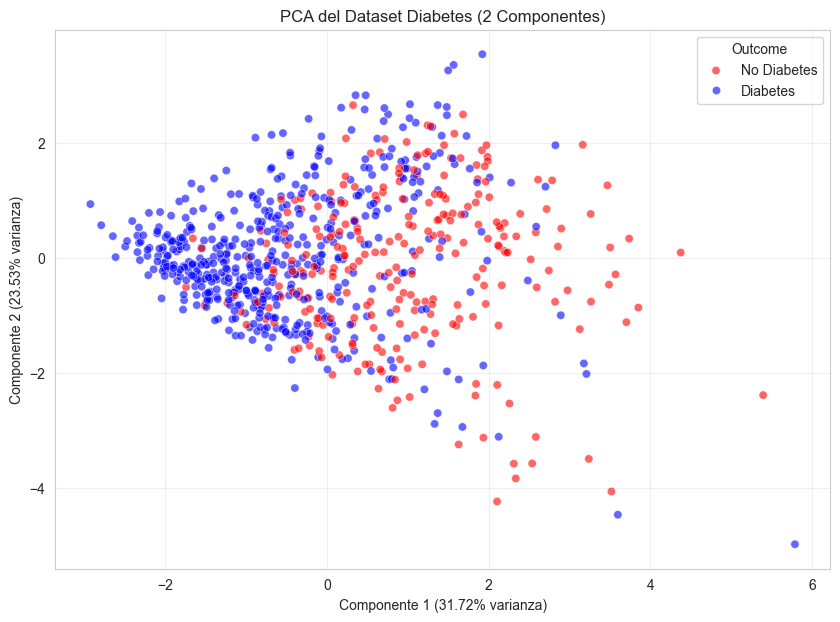

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Preparamos los datos (PCA REQUIERE escalado obligatorio)
# Usamos tus datos limpios (sin ceros)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X es tu dataframe original limpio

# 2. Aplicamos PCA para reducir a 2 dimensiones
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X_scaled)

# Crear DataFrame para graficar
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['Outcome'] = y.values # Añadimos la etiqueta para colorear

# 3. Graficamos
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Outcome', 
    data=pca_df, 
    palette=['blue', 'red'], 
    alpha=0.6
)
plt.title('PCA del Dataset Diabetes (2 Componentes)')
plt.xlabel(f'Componente 1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'Componente 2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.legend(title='Outcome', labels=['No Diabetes', 'Diabetes'])
plt.grid(True, alpha=0.3)
plt.show()

#

Tras realizar el estudio con resampling podríamos intentar hacer PCA. Para ello, con el script anterior hacemos PCA y pintamos las dos primeras componentes del PCA.

El análisis visual mediante PCA de los dos primeros componentes (explicando el 55.25% de la varianza total) revela conclusiones críticas sobre la naturaleza del dataset:

- Solapamiento Estructural (Class Overlap): Existe una mezcla severa entre las clases "Diabetes" y "No Diabetes" en el espacio de características. No se observa una separación lineal ni agrupamientos aislados, lo que confirma que los perfiles biométricos de pacientes sanos y enfermos comparten similitudes significativas.

- Techo de Rendimiento Intrínseco: La falta de fronteras claras indica que el error irreductible del dataset es alto. Esto explica por qué los modelos convergen en un techo de exactitud del ~80%; intentar superar esta barrera mediante modelos más complejos (como Random Forest profundos) conduce inevitablemente al sobreajuste (overfitting), ya que el modelo comienza a memorizar el ruido en lugar de patrones reales.

- Decisión Técnica: Se desaconseja el uso de PCA para la fase de entrenamiento. Reducir la dimensionalidad implicaría perder el 45% de la información restante, exacerbando la mezcla de clases. Por lo que no seguimos explorando esta via.